In [1]:
from PIL import Image
from torchvision import transforms
from src.backbone import Backbone
from src.fpn import FPN
from src.rpn import RPN
from src.head import DetectionHead
import torch

from src.utils.anchor_utils import *
from src.utils.roi_utils import *
from src.utils.training_utils import *

In [2]:
output_layer_map = {
    'conv3': 16,
    'conv4': 23,
    'conv5': 30
}

backbone = Backbone(output_layer_map)

dog_img = Image.open("../data/dog.png")

/home/rmahajani/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rmahajani/anaconda3/envs/faster-rcnn-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv3 16
conv4 23
conv5 30


In [3]:
preprocess = transforms.Compose([
    transforms.Resize((600, 600)),      
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],     # ImageNet mean
        std=[0.229, 0.224, 0.225]       # ImageNet std
    )
])

preprocessed_img = preprocess(dog_img).unsqueeze(0)

preprocessed_img.size()

torch.Size([1, 3, 600, 600])

In [4]:
features = backbone(preprocessed_img)

In [5]:
features.keys()

dict_keys(['conv3', 'conv4', 'conv5'])

In [6]:
print(features['conv3'].size()), print(features['conv4'].size()), print(features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 512, 37, 37])
torch.Size([1, 512, 18, 18])


(None, None, None)

In [7]:
fpn = FPN()
fpn_features = fpn(features)
print(fpn_features['conv3'].size()), print(fpn_features['conv4'].size()), print(fpn_features['conv5'].size())

torch.Size([1, 256, 75, 75])
torch.Size([1, 256, 37, 37])
torch.Size([1, 256, 18, 18])


(None, None, None)

In [8]:
rpn = RPN()
rpn_out = dict()
for k, v in fpn_features.items():
    rpn_out[k] = rpn(v)

In [9]:
rpn_out['conv3'][0].size(), rpn_out['conv4'][0].size(), rpn_out['conv5'][0].size(), rpn_out['conv3'][1].size(), rpn_out['conv4'][1].size(), rpn_out['conv5'][1].size()

(torch.Size([1, 18, 75, 75]),
 torch.Size([1, 18, 37, 37]),
 torch.Size([1, 18, 18, 18]),
 torch.Size([1, 36, 75, 75]),
 torch.Size([1, 36, 37, 37]),
 torch.Size([1, 36, 18, 18]))

In [11]:
img_shape = (600, 600)
feature_map_key = 'conv4'
rpn_deltas = torch.cat([rpn_out[feature_map_key][1]] * 4, dim=0)
feature_map = fpn_features[feature_map_key]
anchors = generate_anchors()

print(rpn_deltas.size(), feature_map.size(), anchors.shape)
sorted_rpn_keys = sorted(rpn_out.keys())

layer_to_shifted_anchors = dict()
for k in sorted_rpn_keys:
    layer_to_shifted_anchors[k] = torch.from_numpy(shift((anchors), rpn_out[k][0].size(2), rpn_out[k][0].size(3), img_shape[0] // rpn_out[k][0].size(2))).to(rpn_out[k][1].device).float()

rois = torch.cat([generate_rois(rpn_out[k][1], layer_to_shifted_anchors[k], img_shape) for k in sorted_rpn_keys], dim=0)
scores = torch.cat([get_scores(rpn_out[k][0]) for k in sorted_rpn_keys], dim=1).squeeze()
# rois = generate_rois(rpn_deltas, anchors, img_shape)
print(rois.size(), scores.size())

unique_batches = rois[:, 0].unique()
all_proposals = []
all_scores = []

for batch_idx in unique_batches:
    batch_mask = rois[:, 0] == batch_idx
    batch_rois = rois[batch_mask]
    batch_scores = scores[batch_mask]

    print(batch_rois.size(), batch_scores.size())

    # Perform NMS on the batch
    keep = nms(batch_rois, batch_scores)
    batch_rois = batch_rois[keep]
    batch_scores = batch_scores[keep]

    sorted_scores, sorted_indices = torch.sort(batch_scores, descending=True)
    sorted_proposals = batch_rois[sorted_indices]

    K = 2000  # for example, adjust K based on your use case
    topk_proposals = sorted_proposals[:K]
    topk_scores = sorted_scores[:K]

    all_proposals.append(topk_proposals)
    all_scores.append(topk_scores)

print(all_proposals[0].size(), all_scores[0].size())
all_proposals = torch.cat(all_proposals, dim=0)
all_scores = torch.cat(all_scores, dim=0)
print(all_proposals.size(), all_scores.size())

all_proposals = all_proposals.detach()
all_scores = all_scores.detach()

gt_batch0 = torch.tensor([
    [0, 50, 50, 150, 150, 1],
    [0, 200, 200, 300, 300, 2]
], dtype=torch.float32)
gt_batch1 = torch.tensor([
    [1, 100, 100, 200, 200, 1],
    [1, 250, 250, 350, 350, 2]
], dtype=torch.float32)
gt = torch.cat([gt_batch0, gt_batch1], dim=0)

sampled_proposals, sampled_labels, sampled_bbox_targets = matching_and_sampling(all_proposals, gt)

print(sampled_proposals.size(), sampled_labels.size(), sampled_bbox_targets.size())

pooled_height, pooled_width = 3, 3

levels = sorted([int(x[-1]) for x in rpn_out.keys()])
aligned_proposals = perform_roi_align(levels, sampled_proposals, fpn_features, pooled_height, pooled_width, img_shape)

print(aligned_proposals.size())

torch.Size([4, 36, 37, 37]) torch.Size([1, 256, 37, 37]) (9, 4)
torch.Size([65862, 5]) torch.Size([65862])
torch.Size([65862, 5]) torch.Size([65862])
torch.Size([2000, 5]) torch.Size([2000])
torch.Size([2000, 5]) torch.Size([2000])
torch.Size([128, 5]) torch.Size([128]) torch.Size([128, 4])
torch.Size([128, 256, 3, 3])


In [12]:
N, C, H, W = aligned_proposals.size()
num_classes = 4

head = DetectionHead(in_channels=C, pooled_height=H, pooled_width=W, num_classes=num_classes)

cls_scores, bbox_deltas = head(aligned_proposals)
pred_boxes = torch.stack([decode_boxes(sampled_proposals[:, 1:], bbox_deltas[:, i:i+4], img_shape) for i in range(num_classes)], dim=1)

print(cls_scores.size(), bbox_deltas.size(), pred_boxes.size())

torch.Size([128, 5]) torch.Size([128, 16]) torch.Size([128, 4, 4])


In [26]:
import torch.nn.functional as F

gt_labels = torch.ones(cls_scores.size(0), dtype=torch.long)
sample_gt_bbox = torch.tensor([[100, 100, 200, 200]], dtype=torch.float32)
gt_bboxes = sample_gt_bbox.expand(pred_boxes.size(0), -1)

loss_cls = F.cross_entropy(cls_scores, gt_labels)
pos_inds = torch.nonzero(gt_labels > 0, as_tuple=False).squeeze(1)

print(pos_inds.size())

# if pos_inds.numel() > 0:


# loss_cls

torch.Size([2000])


In [28]:
import datasets

In [ ]:
# ds = datasets.load_dataset("detection-datasets/coco")
# single_object_ds = ds.filter(lambda example: len(example['objects']['category']) == 1)
# single_object_ds.save_to_disk('./single_object_ds')

Filter: 100%|██████████| 4952/4952 [00:18<00:00, 273.20 examples/s]


In [29]:
single_object_ds = datasets.load_from_disk('../data/single_object_ds/val')

In [30]:
single_object_ds

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 593
})

['bear']


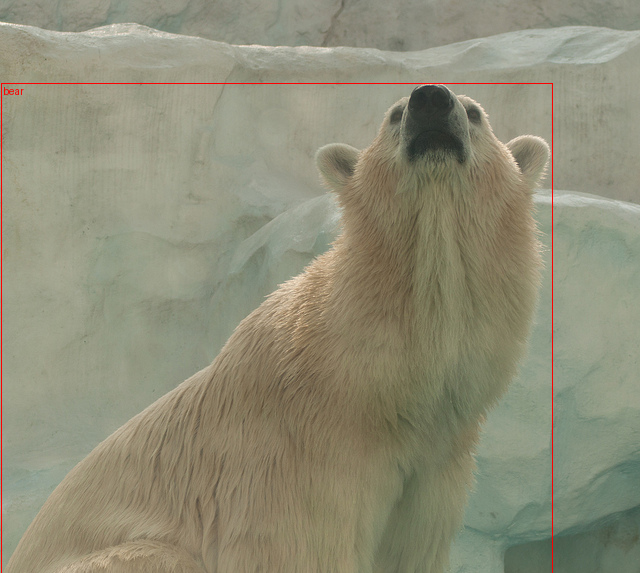

In [73]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image


example = single_object_ds[250]
categories = single_object_ds.features['objects'].feature['category']
boxes_xywh = torch.tensor(example['objects']['bbox'])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [categories.int2str(x) for x in example['objects']['category']]
print(labels)
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(example['image']),
        boxes_xyxy,
        colors="red",
        labels=labels,
    )
)

In [ ]:
import albumentations as A
import cv2

transform_pipeline = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(
            scale_limit=0.1, 
            rotate_limit=15, 
            shift_limit=0.1, 
            p=0.5, 
            border_mode=cv2.BORDER_CONSTANT
        )
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"])
)

